# Importing a GDSII/OASIS Layout

Importing an existing GDSII or OASIS layout file is easy with PhotonForge.
Each cell in the layout is loaded as a [component](../_autosummary/photonforge.Component.rst) and the hierarchical structure in the file is preserved as PhotonForge [references](../_autosummary/photonforge.Reference.rst).

One important aspect to notice is that GDSII and OASIS files do not include a standard way to specify the PDK they use.
That means that we are responsible for loading the appropriate [technology](Technology.ipynb) for the file we want to import.

In this example, we'll load the GDSII file created in the [MZI example](../examples/MZI.ipynb).
That file was created for use with the [basic technology](../_autosummary/photonforge.basic_technology.rst) included in PhotonForge, but with a strip [waveguide profile](Ports.ipynb) with 450 nm core, so we first set that as our default technology.

In [1]:
import photonforge as pf

pf.config.default_technology = pf.basic_technology(strip_width=0.45)

With the technology set, loading the layout is done with the [load_layout](../_autosummary/photonforge.load_layout.rst) function, which returns a dictionary of components by name.

In [2]:
# Load the gds file
gds_file = "../examples/MZI.gds"
components = pf.load_layout(gds_file)
print("Components:", list(components.keys()))

Components: ['DELAY_STRAIGHT_10', 'DELAY_ARM_0', 'BEND', 'DELAY_ARM_10', 'COUPLER', 'MZI']


In [3]:
components["COUPLER"]

If we don't know which of the components are at the top-level in the cell hierarchy in the layout, the [find_top_level](../_autosummary/photonforge.find_top_level.rst) function can provide that information.

In [4]:
top_level = pf.find_top_level(*components.values())
print("Top level components:", [component.name for component in top_level])

Top level components: ['MZI']


In [5]:
mzi = components["MZI"]
mzi

Because we generated the default technology with the appropriate strip waveguide profile for this layout, [adding ports](Ports.ipynb) is easy with [port auto-detection](../_autosummary/photonforge.Component.rst#photonforge.Component.detect_ports):

In [6]:
ports = mzi.detect_ports(["Strip"])
print("Detected ports:" + "\n".join([f" - {p}" for p in ports]))

Detected ports: - Port at (-4.25, -6.55) at 90 deg of type Strip waveguide
 - Port at (-4.25, 0) at 270 deg of type Strip waveguide
 - Port at (18.75, -6.55) at 90 deg of type Strip waveguide
 - Port at (18.75, 0) at 270 deg of type Strip waveguide


In [7]:
mzi.add_port(ports, "P")
mzi

We can continue adding ports and models to all sub-components loaded from the layout to replicate the circuit simulation used in the [original example](../examples/MZI.ipynb).

In [8]:
mzi.add_model(pf.CircuitModel(verbose=False), "Circuit")

'Circuit'

In [9]:
coupler = components["COUPLER"]

coupler.add_port(coupler.detect_ports(["Strip"]), "P")
assert len(coupler.ports) == 4

coupler.add_model(
    pf.Tidy3DModel(
        port_symmetries=[
            ("P0", "P1", {"P1": "P0", "P2": "P3", "P3": "P2"}),
            ("P0", "P2", {"P1": "P3", "P2": "P0", "P3": "P1"}),
            ("P0", "P3", {"P1": "P2", "P2": "P1", "P3": "P0"}),
        ],
        verbose=False,
    ),
    "Tidy3DModel",
)
coupler

In [10]:
arm_0 = components["DELAY_ARM_0"]

arm_0.add_port(arm_0.detect_ports(["Strip"]), "P")
assert len(arm_0.ports) == 2

arm_0.add_model(pf.CircuitModel(verbose=False), "CircuitModel")
arm_0

In [11]:
arm_10 = components["DELAY_ARM_10"]

arm_10.add_port(arm_10.detect_ports(["Strip"]), "P")
assert len(arm_10.ports) == 2

arm_10.add_model(pf.CircuitModel(verbose=False), "CircuitModel")
arm_10

In [12]:
bend = components["BEND"]

bend.add_port(bend.detect_ports(["Strip"]), "P")
assert len(bend.ports) == 2

bend.add_model(
    pf.Tidy3DModel(port_symmetries=[("P0", "P1", {"P1": "P0"})], verbose=False), "Tidy3DModel"
)
bend

In [13]:
straight = components["DELAY_STRAIGHT_10"]

straight.add_port(straight.detect_ports(["Strip"]), "P")
assert len(straight.ports) == 2

straight.add_model(pf.WaveguideModel(verbose=False), "WaveguideModel")
straight

We may check the [netlists](../_autosummary/photonforge.Component.rst#photonforge.Component.get_netlist) of the components with [circuit models](../_autosummary/photonforge.CircuitModel.rst) to make sure we connected all sub-components correctly.
If any sub-component is disconnected or missing a model, we'll get an error or warning when computing the scattering matrix.

Starting...


Progress: 100% 


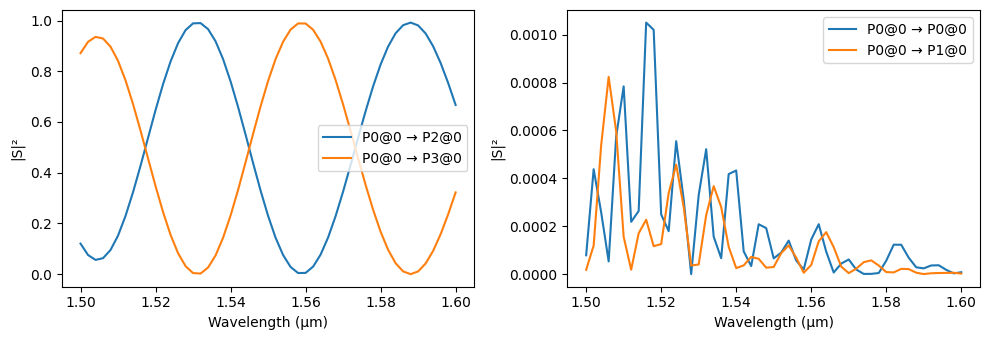

In [14]:
import numpy as np

s_matrix = mzi.s_matrix(pf.C_0 / np.linspace(1.5, 1.6, 51))

_ = pf.plot_s_matrix(s_matrix, input_ports=["P0"])